**Andrew Wang's Data Science 100 Project Proposal**

*Introduction*:  
Heart disease is a serious medical condition that can drastically alter an individual's life. It is important for both data analysts and medical professionals to be able to predict when someone is at risk of developing heart disease as this can lead to immediate lifestyle adjustments/medical attention that can help people live longer. The database I will be analyzing is a collection of variables such as age, sex, and cholesterol from a study on heart disease conducted by Andras Janosi, William Steinburnn, Matthias Pfisterer, and Robert Detrano. The data used in this project will be obtained from the processed data of Hungarian. The purpose of this project and using this database is to answer the following question:  
**"Is it possible to accurately diagnose heart disease based solely on an individual's resting blood pressure and serum cholesterol?"**  
This is a classification problem where in this project, I am going to be building a model that will take in two variables: an individuals resting blood pressure and amount of serum cholesterol and try to predict whether or not this individual will have heart disease.      

*Preliminary exploratory data analysis:*  
The first step in answering my question is to identify the necessary libraries required to complete the data analysis. The following libraries below are going to be used in this project.

In [25]:
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 6)

Next we need to read the data into R. This can be done using the read_csv function as the delim of the data file is a comma. We must also specify in the read_csv function that the data itself does not contain column names.

In [26]:
data <- read_csv("data/heart_disease/processed.hungarian.data", col_names = FALSE)
data

Rows: 294 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (9): X4, X5, X6, X7, X8, X9, X11, X12, X13
dbl (5): X1, X2, X3, X10, X14

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,X11,X12,X13,X14
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
28,1,2,130,132,0,2,185,0,0,?,?,?,0
29,1,2,120,243,0,0,160,0,0,?,?,?,0
29,1,2,140,?,0,0,170,0,0,?,?,?,0
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
56,1,4,155,342,1,0,150,1,3,2,?,?,1
58,0,2,180,393,0,0,110,1,1,2,?,7,1
65,1,4,130,275,0,1,115,1,1,2,?,?,1


We have successfully loaded the data into R, but it is not in a tidy format. We must clean and wrangle the data to make it visually appearing and easier to work with.

In [27]:
data <- data |>
        rename(resting_blood_pressure = X4, cholestoral = X5, heart_disease = X14)


In [28]:
data <- select(data, resting_blood_pressure, cholestoral, heart_disease) |>
        filter(resting_blood_pressure != "?") |>
        filter(cholestoral != "?") |>
        filter(heart_disease != "?")

In [29]:
data <- data %>%
        mutate(heart_disease = case_when(
            heart_disease == 0 ~ 0,
            heart_disease %in% c(1, 2, 3, 4) ~ 1
            ))

In [30]:
data <- mutate(data, resting_blood_pressure = as.double(resting_blood_pressure)) 
data <- mutate(data, cholestoral = as.double(cholestoral))
data <- mutate(data, heart_disease = as.factor(heart_disease))

We have selected the columns we are going to be using and changed them to double, added column names, removed missing values, and changed the heart_disease to contain only values of 0 and 1 where 0 represents no heart disease and 1 is any degree of heart disease. Now the data must be split into 2 sections: one for training the model and one for testing the model.

In [31]:
set.seed(573)
data_split <- initial_split(data, prop = 0.75, strata = heart_disease)
data_train <- training(data_split)
data_test <- testing(data_split)

In [39]:
summary_data_mean <- data_train |>
        summarize(average_rbp = mean(resting_blood_pressure), average_cholestoral = mean(cholestoral))
summary_data_count <- data_train |>
                      summarize(number_of_heart_disease = nrow(filter(data_train, heart_disease == 1)))
summary_data_count
summary_data_mean

number_of_heart_disease
<int>
75


average_rbp,average_cholestoral
<dbl>,<dbl>
132.6567,249.393


Here we can see the number of cases where the patient was identified to have heart disease, and the average resting blood pressure and average cholestoral of the entire dataset.

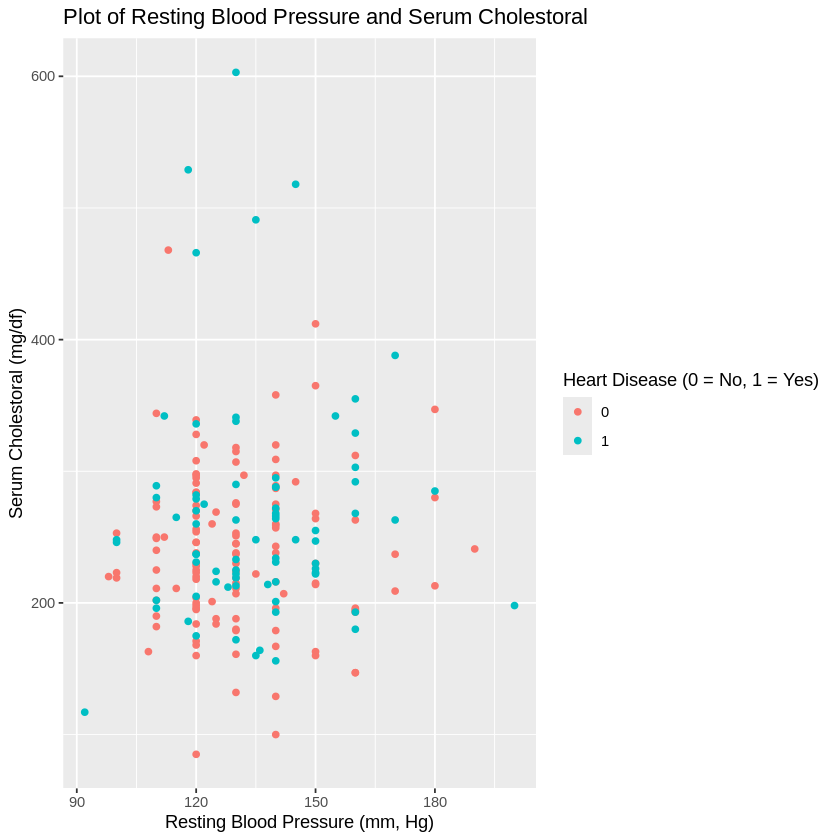

In [42]:
training_plot <- data_train |>
                 ggplot(aes(x = resting_blood_pressure, y = cholestoral, color = heart_disease)) +
                 geom_point() +
                 labs(x = "Resting Blood Pressure (mm, Hg)", y = "Serum Cholestoral (mg/df)", color = "Heart Disease (0 = No, 1 = Yes)") +
                 ggtitle("Plot of Resting Blood Pressure and Serum Cholestoral")
training_plot

*Methods:* 

The first step that must be done before building the model is to standardize the variables. Just by looking at the plot above, it is clear that the cholestoral levels have a much higher variance than resting blood pressure. If we were to not standardize the variables, the K-nearest-neighbor algorithm will choose a data point's neighbour based primarily on cholestoral level, rather than prioritizing both cholestoral and resting blood pressure equally. This leads to incorrect predictions being made by the model which is what we do not want. The next steps would be to find the most ideal K value that has the highest accuracy percentage, and then to build a recipe and model using the K value obtained. Finally, it would all be added into a workflow where we can test it using the testing set we had previously created. One way to visualize the results would be two side-by-side scatter plots where one plot is the actual values of heart_disease and the other is the predicited value. This side-by-side comparison allows for easy analysis on whether the model predicted well or not.  

*Expected outcome and significance:*  

I predict that the model will have a low accuracy rate and be quite inaccurate. By looking at the plot above, it seems like there is no clear distinction between resting blood presure and cholestoral, making it hard for the model to classify based on the surrounding neighbors. The impact of this result, whatever it might entail, would tell those in the medical field what variables are actually important in dictating whether a patient has heart disease or not. If the model is inaccurate, a future question could be what other variables are necessary to consider when diagnosing heart disease.


*Data Analysis:*  
When using the k-nearest-neighbor algorithm, the most important step of using this algorithm is to determine the best value of K that will give us the most accuracte predictions. This will be done by performing cross validation. 

In [47]:
set.seed(573)
data_recipe <- recipe(heart_disease ~ resting_blood_pressure + cholestoral, data = data_train) |>
                step_scale(all_predictors()) |>
                step_center(all_predictors())
data_vfold <- vfold_cv(data_train, v = 5, strata = heart_disease)
data_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
                set_engine("kknn") |>
                set_mode("classification")
neighbors <- tibble(neighbors = seq(from = 1, to = 10, by = 1))
data_results <- workflow() |>
                add_recipe(data_recipe) |>
                add_model(data_tune) |>
                tune_grid(resamples = data_vfold, grid = neighbors) |>
                collect_metrics()
data_results

neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
1,accuracy,binary,0.5773171,5,0.02115282,Preprocessor1_Model01
1,roc_auc,binary,0.5523590,5,0.02821636,Preprocessor1_Model01
2,accuracy,binary,0.5773171,5,0.02258190,Preprocessor1_Model02
⋮,⋮,⋮,⋮,⋮,⋮,⋮
9,roc_auc,binary,0.5264205,5,0.04637114,Preprocessor1_Model09
10,accuracy,binary,0.5818293,5,0.02513970,Preprocessor1_Model10
10,roc_auc,binary,0.5276821,5,0.04429480,Preprocessor1_Model10


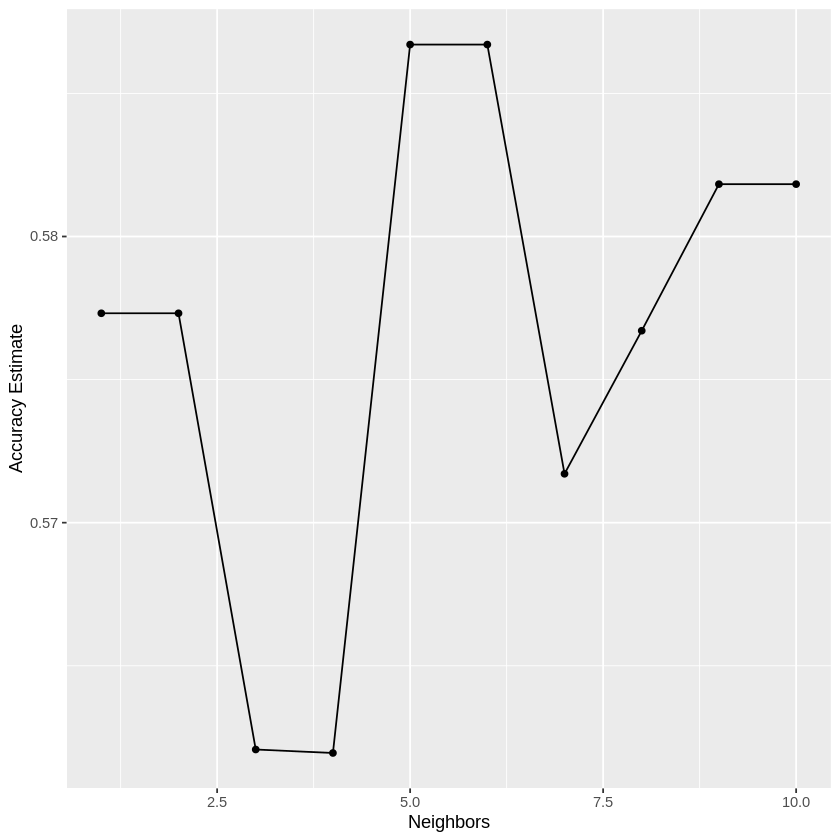

In [45]:
accuracy <- data_results |>
            filter(.metric == "accuracy")
best_k_plot <- accuracy |>
                ggplot(aes(x = neighbors, y = mean)) +
                geom_point() +
                geom_line() +
                labs(x = "Neighbors", y = "Accuracy Estimate")   
best_k_plot